# Baseline Model

In [1]:
from recognizer.utils. constants import DATA_DIR, ROOT_DIR

IMAGES_DIR = DATA_DIR / "preprocessed-10p" / "images"
MASKS_DIR = DATA_DIR / "preprocessed-10p" / "masks"
CHECKPOINTS_DIR = ROOT_DIR / "models"

In [2]:
from dotenv import load_dotenv

load_dotenv(ROOT_DIR / ".env")

True

In [3]:
import os

image_to_mask_map = dict()

for img_file in os.listdir(IMAGES_DIR):
    image_to_mask_map[img_file] = img_file.replace("image", "mask")


In [4]:
image_filenames = list(image_to_mask_map.keys())
mask_filenames = [image_to_mask_map[image] for image in image_filenames]

In [5]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(image_filenames, mask_filenames, test_size=0.1, random_state=180)
images_train, images_val, masks_train, masks_val = train_test_split(images_train, masks_train, test_size=0.1127, random_state=180) # 0.1 * 0.9 = 0.1127

In [6]:
len(images_train), len(images_val), len(images_test)

(408, 52, 52)

In [7]:
import torch

from torchvision.transforms import v2

image_transform = v2.Compose([
    v2.ToTensor()
    # v2.ToImage(),
    # v2.ToDtype(torch.float32, scale=True),
])

mask_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32)
    # v2.ToImage(),
    # v2.ToDtype(torch.float32, scale=True),
])

c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\football-players-recognizer-LaIM_g6P-py3.10\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
from recognizer.datasets import SegmentationDataset

train_dataset = SegmentationDataset(
    images_dir=str(IMAGES_DIR),
    masks_dir=str(MASKS_DIR),
    image_files=images_train,
    mask_files=masks_train,
    transform=image_transform,
    target_transform=mask_transform
)

val_dataset = SegmentationDataset(
    images_dir=str(IMAGES_DIR),
    masks_dir=str(MASKS_DIR),
    image_files=images_val,
    mask_files=masks_val,
    transform=image_transform,
    target_transform=mask_transform
)

test_dataset = SegmentationDataset(
    images_dir=str(IMAGES_DIR),
    masks_dir=str(MASKS_DIR),
    image_files=images_test,
    mask_files=masks_test,
    transform=image_transform,
    target_transform=mask_transform
)

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4, pin_memory=True)

In [10]:
from recognizer.models.unet import UNet

unet_model = UNet(n_channels=3, n_classes=1)

In [26]:
import lightning as L
from torch import nn
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torchmetrics.classification import BinaryJaccardIndex, Dice


early_stopping = EarlyStopping(monitor="val_loss", mode="min")


class LitSegmenter(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.dice = Dice()
        self.iou = BinaryJaccardIndex()
        self.example_input_array = torch.rand(BATCH_SIZE, 3, 216, 384)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        images, masks = batch
        
        outputs = self.model(images)

        loss = self.loss_fn(outputs, masks)

        self.log("train_loss", loss)

        return loss


    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        images, masks = batch

        outputs = self.model(images)

        loss = self.loss_fn(outputs, masks)

        self.log("val_loss", loss)


    def test_step(self, batch, batch_idx):
        images, masks = batch

        outputs = self.model(images)

        loss = self.loss_fn(outputs, masks)
        dice = self.dice(outputs, masks.int())
        iou = self.iou(outputs, masks.int())
        self.log_dict({"test_loss": loss, "dice": dice, "iou": iou}, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def forward(self, x):
        return self.model(x)


segmenter = LitSegmenter(model=unet_model)

In [12]:
from lightning.pytorch.loggers import MLFlowLogger

mlf_logger = MLFlowLogger(experiment_name="Football Players Segmentation", tracking_uri=os.environ["MLFLOW_TRACKING_URI"], run_name="UNet 01", log_model="all")

In [13]:
trainer = L.Trainer(
    max_epochs=50,
    check_val_every_n_epoch=2,
    accelerator="gpu",
    devices=1,
    callbacks=[early_stopping],
    default_root_dir=str(CHECKPOINTS_DIR),
    logger=mlf_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
import mlflow

mlflow.pytorch.autolog()

2024/06/02 19:42:56 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.


In [15]:
trainer.fit(model=segmenter, train_dataloaders=train_loader, val_dataloaders=val_loader)

2024/06/02 19:43:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1b8a28dc06f540a7843f87c1d461db38', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow
2024/06/02 19:43:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\football-players-recognizer-LaIM_g6P-py3.10\lib\site-packages\mlflow\pytorch\_lightning_autolog.py:356: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.4.9 and 2.1.2 and may not succeed with packages outside this range."
Experiment with name Football Players Segmentation not found. Creating it.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | In sizes          | Out sizes        
--------------------------------------------------------------------------------------
0 | model   | UNet          

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\football-players-recognizer-LaIM_g6P-py3.10\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\football-players-recognizer-LaIM_g6P-py3.10\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\football-players-recognizer-LaIM_g6P-py3.10\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
2024/06/02 20:06:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [27]:
trainer.test(model=segmenter, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\football-players-recognizer-LaIM_g6P-py3.10\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          dice              0.8909498453140259
           iou              0.8154725432395935
        test_loss           0.05411260947585106
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.05411260947585106,
  'dice': 0.8909498453140259,
  'iou': 0.8154725432395935}]

## Inference

In [29]:
run_id = "1b8a28dc06f540a7843f87c1d461db38"

model_uri = f"runs:/{run_id}/model"
loaded_model = mlflow.pytorch.load_model(model_uri)

In [37]:
import numpy as np
import matplotlib.pyplot as plt

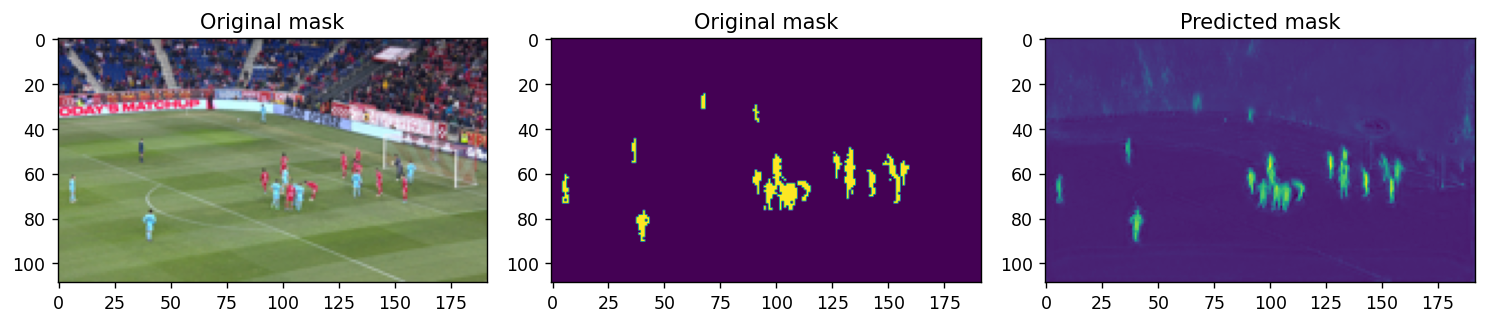

In [72]:
X = test_dataset[int(np.random.random()*len(test_dataset))]

image = X[0].unsqueeze(0)

with torch.inference_mode():
    y_pred = loaded_model(image)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 8), dpi=125)

axs[0].set_title("Original mask")
axs[0].imshow(X[0].permute(1, 2, 0))

axs[1].set_title("Original mask")
axs[1].imshow(X[1].permute(1, 2, 0))

axs[2].set_title("Predicted mask")
axs[2].imshow(y_pred.squeeze(0).permute(1, 2, 0))

plt.tight_layout()